<h1> Introdução </h1>

<p> O tema selecionado para análise foi a <b>Avaliação de Risco de Crédito</b> por sua relevância no mercado econômico e financeiro bem como por sua complexidade, fomentando a aplicação comparativa de diversas técnicas de análises preditivas </p>

<h3> Fonte de Dados </h3>
<p> A base de dados utilizada neste estudo foi obtida no site de competições em ciência de dados kaggle.com, <a href=https://www.kaggle.com/wendykan/lending-club-loan-data/home>Lending Club Load Data </a> e consiste em um conjunto de dados completo de empréstimos concedidos a clientes entre 2007-2015, incluindo o status atual do empréstimo (calculado até à data de publicação do dataset). 
<br>Os recursos adicionais incluem pontuação de crédito, número de consultas financeiras, endereço entre outros. O arquivo é uma tabela de cerca de 890 mil observações e 75 variáveis. Um dicionário de dados (table metadata) é fornecido em um arquivo separado </p>

<h3>Objetivo</h3>
<p>Contruir um modelo que preveja se um pedido de empréstimo será honrado ou não</p>

<h3>Metodologia</h3>
<p>A metodologia de análise será composta das seguintes etapas</p>
<ol>
    <li>Avaliação Preliminar</li>
    <li>Análise Gráfica</li>
    <li>Análise Descritiva</li>
    <li>Análise Bivariada</li>
    <li>Treinamento do modelo: <b>Regressão Logística</b></li>
    <li>Treinamento do modelo: <b>Árvore de Decisão</b></li>
    <li>Comparação de Performance</li>
    <li>Conclusão</li>
</ol>



<h2>1 - Avaliação Preliminar</h2>
<ul>
    <li>Leitura da base de dados</li>
    <li>Validação do tamanho da base</li>
    <li>Compreensão das variáveis disponíveis</li>
    <li>Quantificação dos valores faltantes (missing values)</li>
    <li>Identificação da variávei alvo <b>(target)</b></li>
</ul>


<h3>Leitura da base de dados</h3>

In [1]:
#importing python data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

#configuring appearence styles
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

In [2]:
raw_data = pd.read_csv('../loan.csv',low_memory=False)
df = raw_data.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h4>Visualização do tamanho e dimensões da base </h4>

In [3]:
shape = df.shape
print("As dimensões da base são: \n\n \
        Quantidade de Observações: {} \n \
        Quantidade de Variáveis  : {}".format(shape[0],shape[1]))

As dimensões da base são: 

         Quantidade de Observações: 887379 
         Quantidade de Variáveis  : 74


<h4>Visualização dos nomes e metadados das colunas para compreensão das variáveis disponíveis</h4> 
<p>Neste ponto, o arquivo de metadados disponibilizado pelo kaggle é utilizado para compreender o significado de cada variável existente no dataset </p>

In [16]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [17]:
df_metadata = pd.read_excel(io='../LCDataDictionary.xlsx').dropna()
df_metadata.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


<h4> Quantificação dos valores faltantes (missing)</h4>

In [27]:
#Definição de função de avaliação quantitativa de valores ausentes em um dado Pandas.DataFrame
def missing_values(dataframe):
        mis_val = dataframe.isnull().sum()
        mis_val_percent = 100 * (dataframe.isnull().sum() / len(dataframe))
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0
        ].sort_values(
            '% of Total Values', ascending=False
        ).round(1)
        
        print("O Dataset possui " + str(df.shape[1]) + " colunas.\n"
                + str(mis_val_table_ren_columns.shape[0]) + 
                " Colunas possuem valores ausentes.")
        
        return mis_val_table_ren_columns
    
#Quantifica os valores faltantes no dataset estudado    
missing_statistics = missing_values(df)

O Dataset possui 74 colunas.
39 Colunas possuem valores ausentes.


,Missing Values,% of Total Values
dti_joint,886870,99.9
annual_inc_joint,886868,99.9
verification_status_joint,886868,99.9
il_util,868762,97.9
mths_since_rcnt_il,866569,97.7
total_cu_tl,866007,97.6
inq_fi,866007,97.6
all_util,866007,97.6
max_bal_bc,866007,97.6
open_rv_24m,866007,97.6


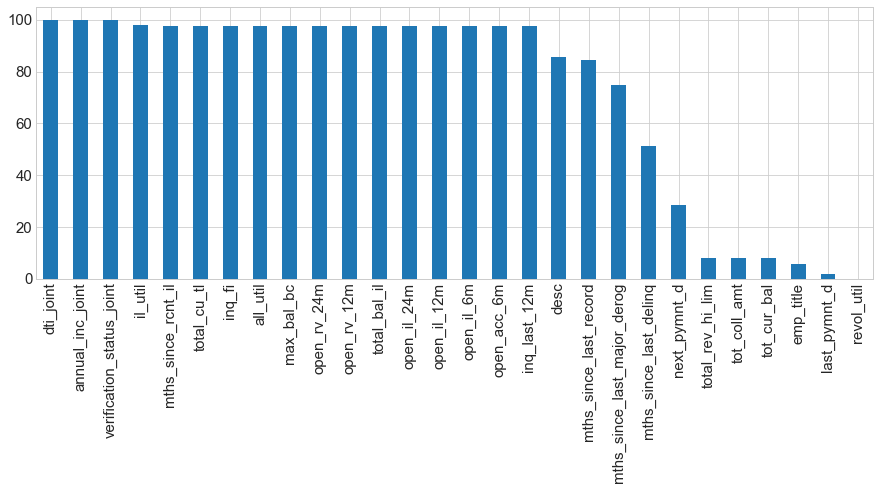

In [47]:
missing_statistics[
                   missing_statistics['% of Total Values'] > 0.0
                  ]['% of Total Values'].plot(
                        kind='bar',
                        figsize=(15,5),
                        fontsize=15
                    )

<p> O gráfico acima mostra que a base de dados possui algumas colunas com um percentual muito alto de observações nulas ou faltantes (acima de 75%, exemplos: `dti_joint`,`annual_inc_joint`,`verification_status_joint`) e que deverão ser tratadas </p>

<h4> Identificação da variávei alvo (target)</h4>
<p>A coluna que contém a variável alvo do estudo é a <b>Loan Status</b>. Esta variável representa a situação corrente do título de empréstimo no momento da publicação do dataset (Current, Late, Fully Paid, etc...).</p>

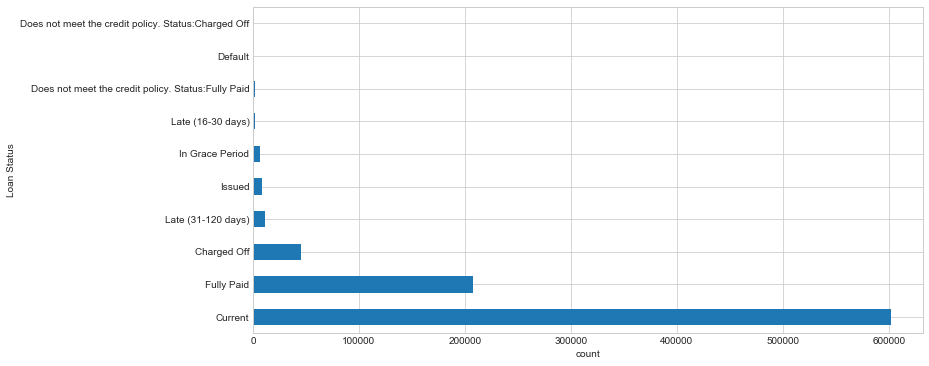

In [48]:
plt.figure(figsize=(12,6))
plt.ylabel('Loan Status')
plt.xlabel('count')
df['loan_status'].value_counts().plot(kind='barh',grid=True)
plt.show()